#### Instructions:  
1. Libraries allowed: **Python basic libraries, numpy, matplotlib, and OpenCV.**
2. Show/visualize all outputs.
3. Submit jupyter notebook and a pdf export of the notebook. Otherwise, you will not get any credits.
   


## Introduction
In this assignment, you will perform calibration of individual camera and then calibration of a stereo setup.

## Tutorials
Go over the tutorials below:
1. Create calibratioin pattern (https://docs.opencv.org/4.x/da/d0d/tutorial_camera_calibration_pattern.html)
2. Camera Calibration (https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html)


#### Q1. Camera calibration with stock dataset

a) Download the attached dataset of image pairs taken by stereo cameras, where the cameras are separated by pure rotation only. 

b) Calibrate the left camera and show the calibatted intrinsic matrix. Display the detected corners for each of the images and finally evaulate with reprojection error.

In [1]:
import numpy as np
import cv2 as cv
import glob
import os
import matplotlib.pyplot as plt

# Ensure plots appear inline in Jupyter
%matplotlib inline

print(f"OpenCV version: {cv.__version__}")

def find_chessboard_corners_in_images(image_paths, chessboard_size, criteria, objp_template, display_inline=True):

    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.
    valid_fnames = [] # Basenames of images where corners were successfully found
    img_shape = None  # To store image shape (width, height)

    if not image_paths:
        print("Warning: No image paths provided.")
        return objpoints, imgpoints, valid_fnames, img_shape

    print(f"Processing {len(image_paths)+1} images...")

    # --- Setup plot for inline display ---
    axes = None
    fig = None
    img_idx_plot = 0
    if display_inline:
        num_images = len(image_paths)
        cols = 4
        rows = (num_images + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
        axes = axes.ravel() # Flatten for easy iteration

    # --- Process each image ---
    for i, fname_path in enumerate(image_paths):
        fname_base = os.path.basename(fname_path)
        img = cv.imread(fname_path)
        status = "Read Error" # Default status if read fails

        if img is None:
            print(f"  Warning: Could not read image {fname_base}. Skipping.")
        else:
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            current_shape = gray.shape[::-1]

            # Determine image shape from the first valid image
            if img_shape is None:
                img_shape = current_shape
                print(f"  Detected image shape: {img_shape}")
            # Check for shape consistency
            elif current_shape != img_shape:
                print(f"  Warning: Image {fname_base} has shape {current_shape}, expected {img_shape}. Skipping.")
                status = "Shape Mismatch"
                # Don't process this image further for points, just display if needed
                if display_inline and i < len(axes):
                     axes[i].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
                     axes[i].set_title(f"{fname_base}\n{status}")
                     axes[i].axis('off')
                     img_idx_plot +=1
                continue # Skip to next image

            # Find the chess board corners
            ret, corners = cv.findChessboardCorners(gray, chessboard_size, None)

            # If found, add object points, refine image points
            if ret == True:
                objpoints.append(objp_template)
                valid_fnames.append(fname_base)

                corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
                imgpoints.append(corners2)
                print(f"  Chessboard found in {fname_base}")
                status = "Corners Found"

                # Draw corners if displaying
                if display_inline:
                    cv.drawChessboardCorners(img, chessboard_size, corners2, ret)
            else:
                print(f"  Warning: Chessboard not found in {fname_base}.")
                status = "Corners NOT Found"

        # --- Display image ---
        if display_inline and i < len(axes):
             if img is not None: # Check if image was read successfully
                 axes[i].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
                 axes[i].set_title(f"{fname_base}\n{status}")
                 axes[i].axis('off')
             else: # Handle case where image read failed
                 axes[i].set_title(f"{fname_base}\n{status}")
                 axes[i].text(0.5, 0.5, status, horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
                 axes[i].axis('off')
             img_idx_plot += 1


    # --- Finalize plot ---
    if display_inline and fig is not None:
        # Hide any remaining empty subplots
        for j in range(img_idx_plot, len(axes)):
             axes[j].set_visible(False)
        plt.tight_layout()
        plt.show()

    if img_shape is None:
        print("Warning: Could not determine image shape (no valid images found?).")

    print(f"Found corners in {len(valid_fnames)+1} out of {len(image_paths)+1} images.")
    return objpoints, imgpoints, valid_fnames, img_shape


def calibrate_and_evaluate(objpoints, imgpoints, img_shape):

    if not objpoints or not imgpoints:
        print("Error: Cannot calibrate without object points and image points.")
        return False, None, None, None, None, None
    if img_shape is None:
        print("Error: Cannot calibrate without image shape.")
        return False, None, None, None, None, None

    print(f"\nPerforming camera calibration using {len(objpoints)+1} views...")
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, img_shape, None, None)

    mean_error = None
    if ret:
        print("Calibration successful!")
        # --- Reprojection Error Evaluation ---
        total_error = 0
        for i in range(len(objpoints)):
            imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
            # Calculate error per point before averaging over the image
            error_per_image = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2) / len(imgpoints2)
            total_error += error_per_image
        mean_error = total_error / len(objpoints)
        print(f"Total Mean Reprojection Error: {mean_error:.5f} pixels")
    else:
        print("Calibration failed.")

    return ret, mtx, dist, rvecs, tvecs, mean_error

OpenCV version: 4.10.0


--- Processing Left Camera ---
Processing 14 images...
  Detected image shape: (640, 480)
  Chessboard found in left01.jpg
  Chessboard found in left02.jpg
  Chessboard found in left03.jpg
  Chessboard found in left04.jpg
  Chessboard found in left05.jpg
  Chessboard found in left06.jpg
  Chessboard found in left07.jpg
  Chessboard found in left08.jpg
  Chessboard found in left09.jpg
  Chessboard found in left11.jpg
  Chessboard found in left12.jpg
  Chessboard found in left13.jpg
  Chessboard found in left14.jpg


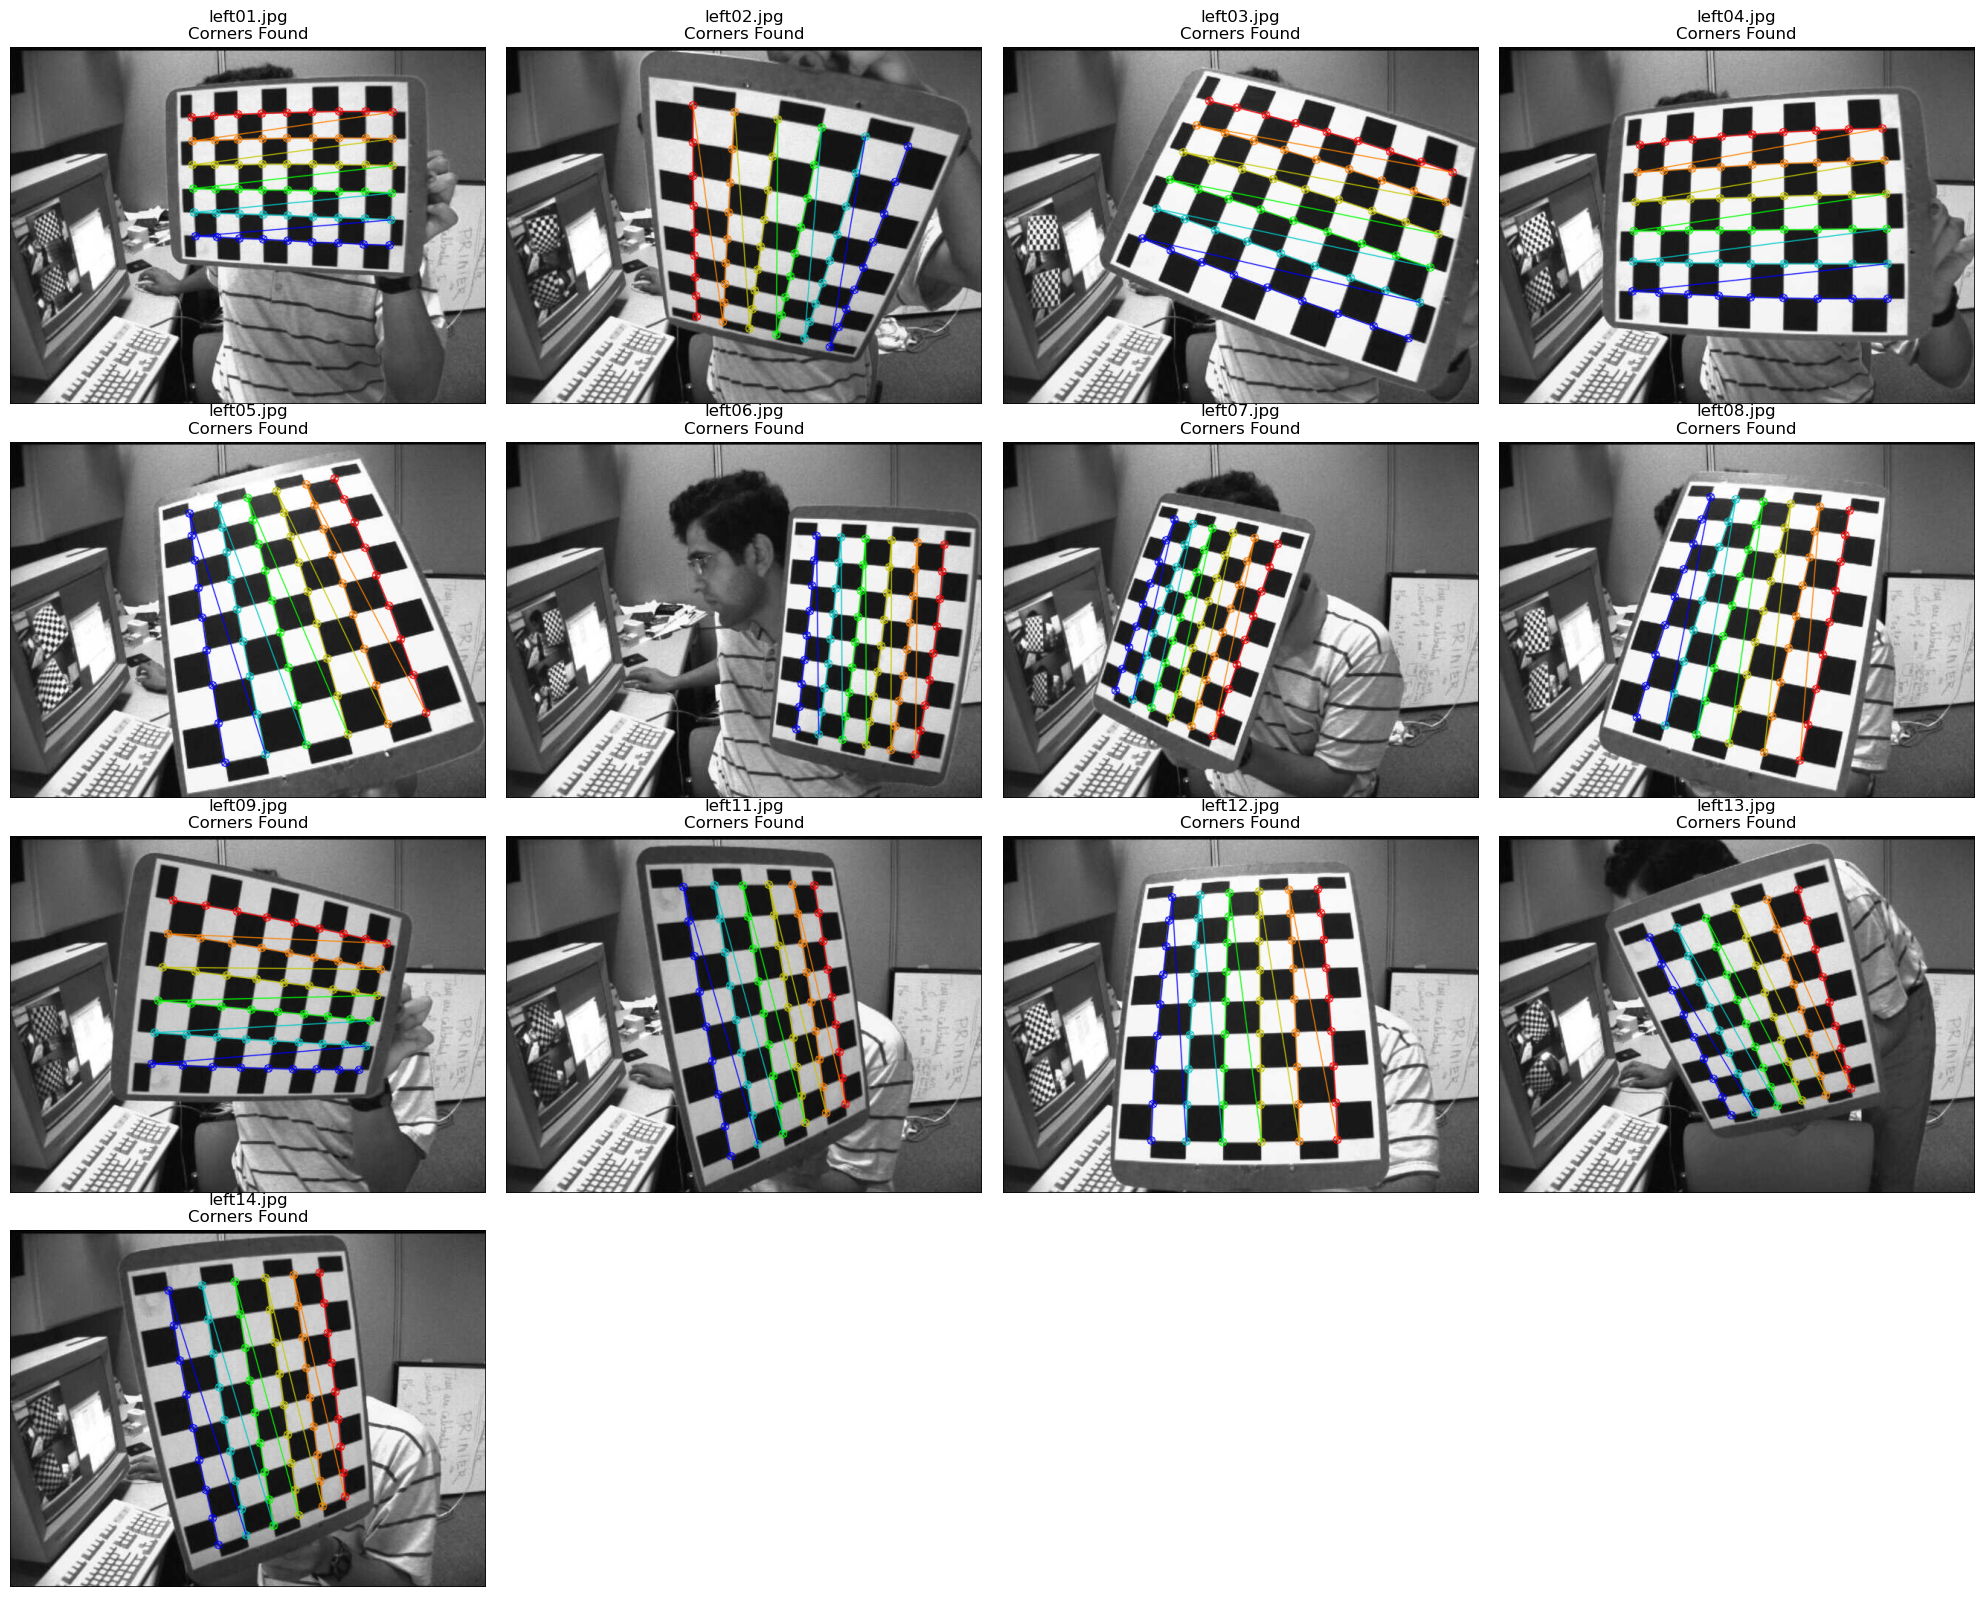

Found corners in 14 out of 14 images.

Performing camera calibration using 14 views...
Calibration successful!
Total Mean Reprojection Error: 0.04096 pixels

Left Camera Intrinsic Matrix (mtx_L):
[[536.0735   0.     342.3705]
 [  0.     536.0164 235.5369]
 [  0.       0.       1.    ]]

Left Distortion Coefficients (dist_L):
[[-0.2651 -0.0467  0.0018 -0.0003  0.2523]]


In [2]:
# --- Configuration ---
chessboard_size = (9, 6)
image_dir = './Stereo_dataset'
left_image_pattern = 'left*.jpg'
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points template (unit size)
objp_template = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp_template[:,:2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1,2)

# --- Find Corners ---
print(f"--- Processing Left Camera ---")
left_images_paths = sorted(glob.glob(os.path.join(image_dir, left_image_pattern)))
objpoints_L, imgpoints_L, valid_left_fnames, img_shape_L = find_chessboard_corners_in_images(
    left_images_paths, chessboard_size, criteria, objp_template, display_inline=True
)

# --- Calibrate ---
ret_L, mtx_L, dist_L, rvecs_L, tvecs_L, error_L = calibrate_and_evaluate(
    objpoints_L, imgpoints_L, img_shape_L
)

# --- Display Results ---
if ret_L:
    print("\nLeft Camera Intrinsic Matrix (mtx_L):")
    print(np.round(mtx_L, 4))
    print("\nLeft Distortion Coefficients (dist_L):")
    print(np.round(dist_L, 4))
    # error_L already printed by the function

c) Calibrate the right camera and show the calibarted intrinsic matrix. Display the detected corners for each of the images and finally evaulate with reprojection error.


--- Processing Right Camera ---
Processing 14 images...
  Detected image shape: (640, 480)
  Chessboard found in right01.jpg
  Chessboard found in right02.jpg
  Chessboard found in right03.jpg
  Chessboard found in right04.jpg
  Chessboard found in right05.jpg
  Chessboard found in right06.jpg
  Chessboard found in right07.jpg
  Chessboard found in right08.jpg
  Chessboard found in right09.jpg
  Chessboard found in right11.jpg
  Chessboard found in right12.jpg
  Chessboard found in right13.jpg
  Chessboard found in right14.jpg


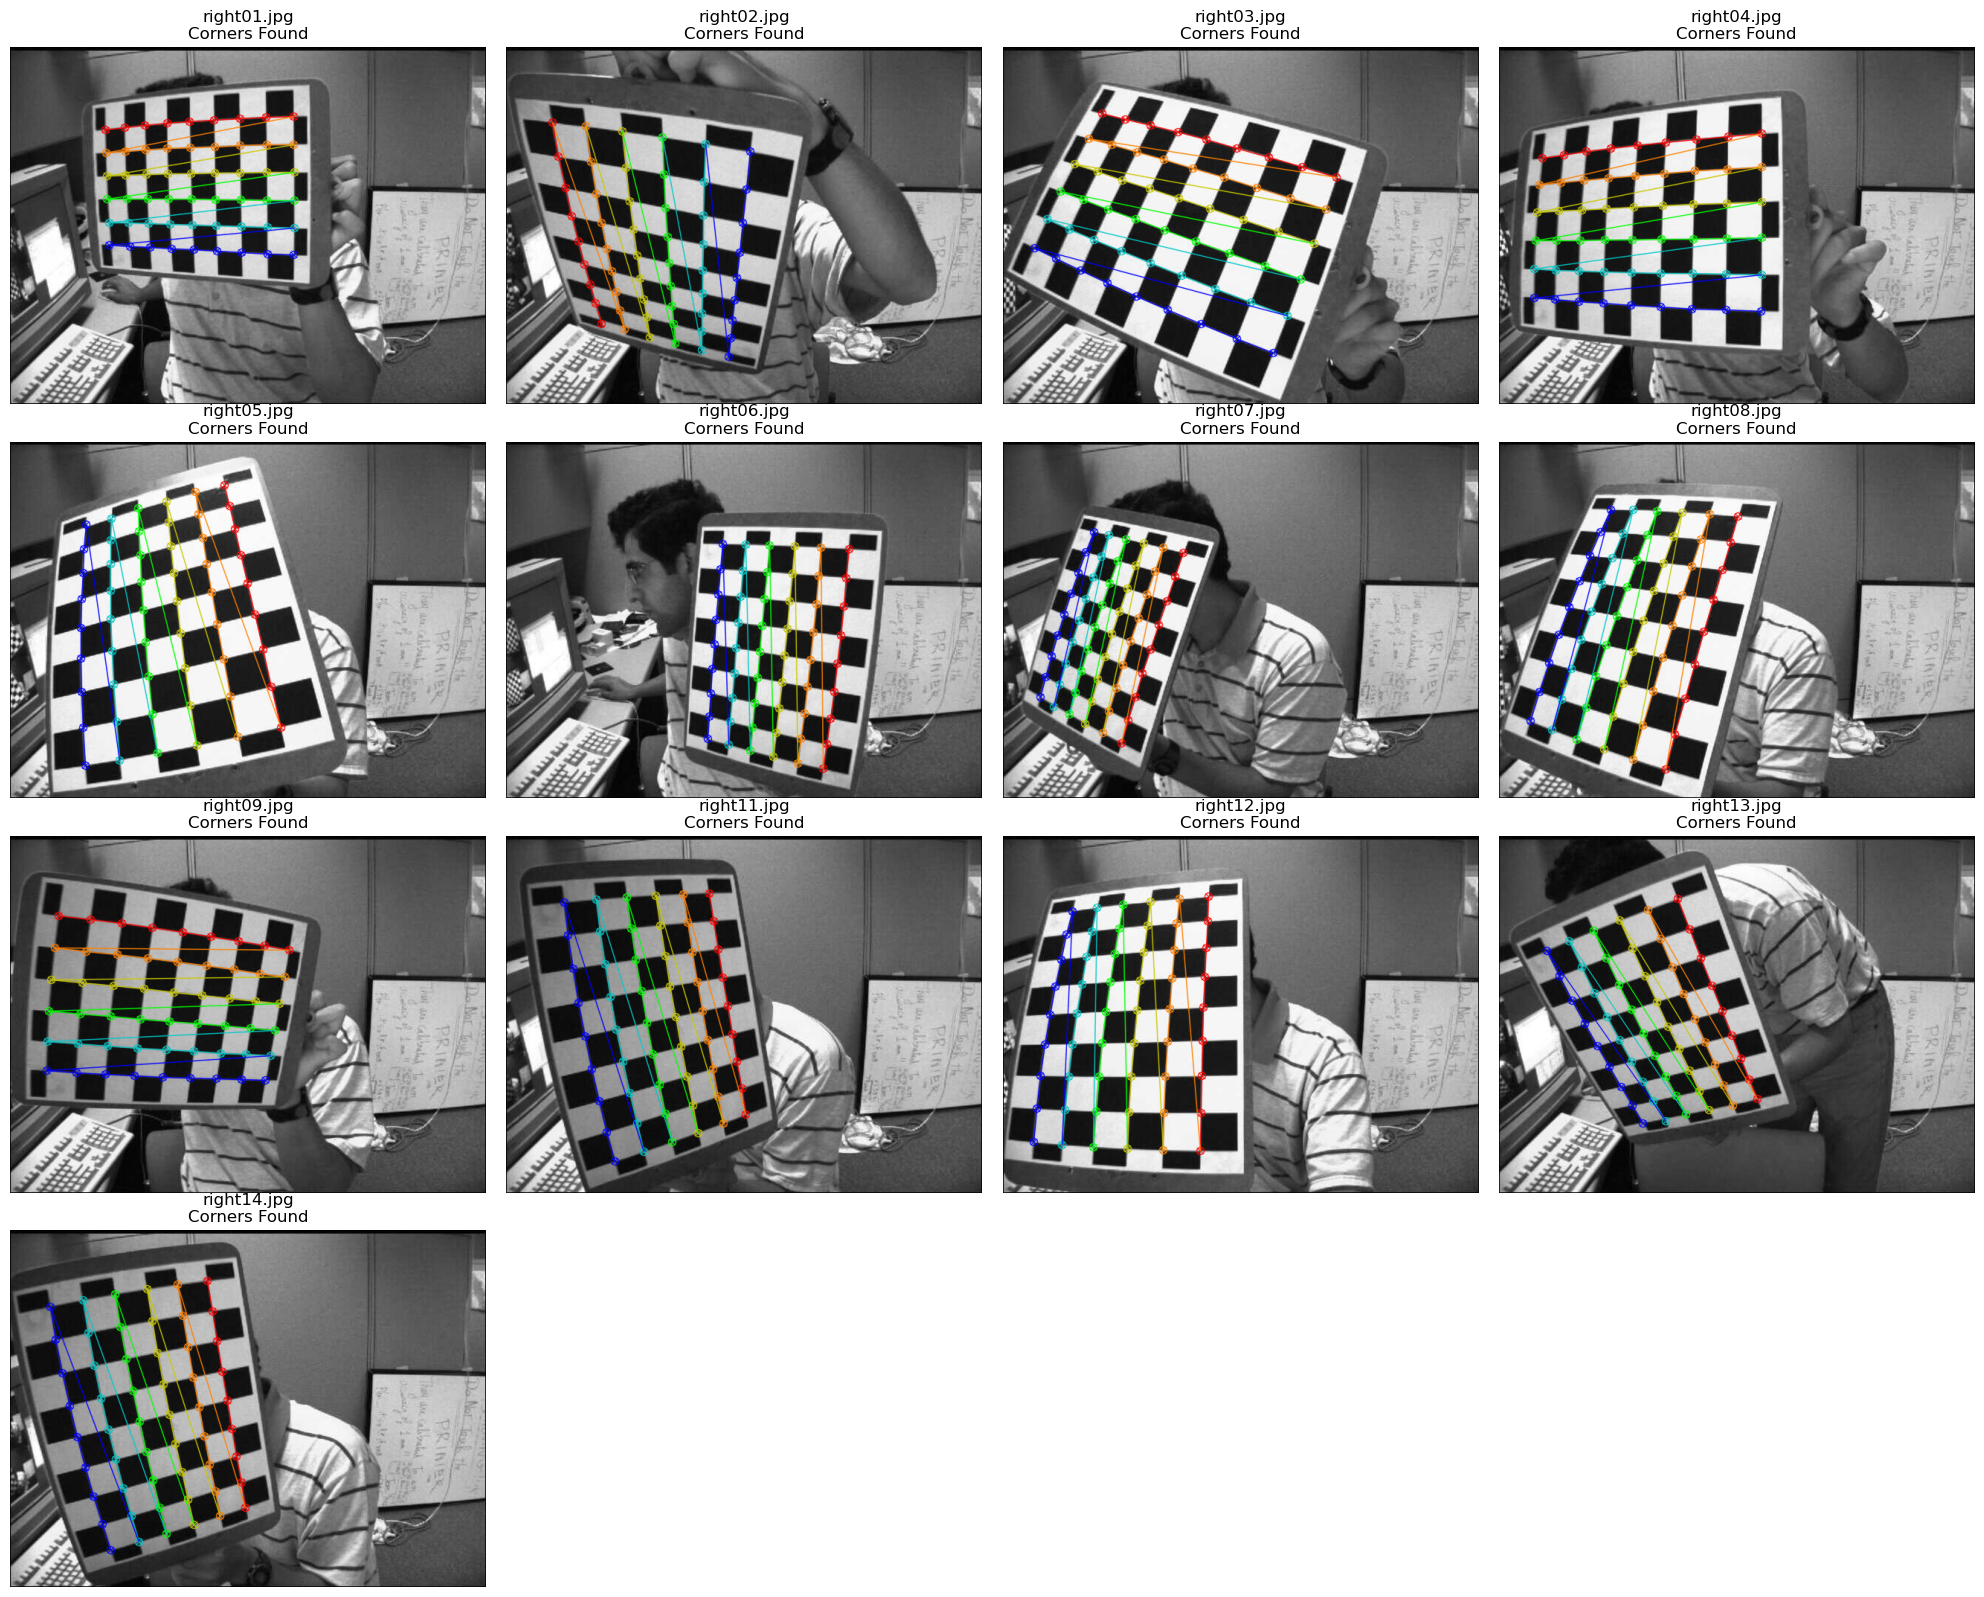

Found corners in 14 out of 14 images.

Filtering 13 valid right images against 13 valid left images...
Kept 13 right images that form valid pairs.

Performing camera calibration using 14 views...
Calibration successful!
Total Mean Reprojection Error: 0.04881 pixels

Right Camera Intrinsic Matrix (mtx_R):
[[542.3549   0.     328.3242]
 [  0.     541.6152 246.9473]
 [  0.       0.       1.    ]]

Right Distortion Coefficients (dist_R):
[[-0.2805  0.1043 -0.0006  0.0013 -0.0237]]


In [3]:
# --- Configuration ---
right_image_pattern = 'right*.jpg'

# --- Find Corners in ALL Right Images First ---
print(f"\n--- Processing Right Camera ---")
right_images_paths = sorted(glob.glob(os.path.join(image_dir, right_image_pattern)))

# Use display_inline=False if only want to show pairs later, or True to see all
objpoints_R_all, imgpoints_R_all, valid_right_fnames_all, img_shape_R = find_chessboard_corners_in_images(
    right_images_paths, chessboard_size, criteria, objp_template, display_inline=True
)

# --- Filter Points for Valid Pairs ---
objpoints_R_paired = []
imgpoints_R_paired = []
valid_right_fnames_paired = []

# Check if left camera processing was successful
if 'valid_left_fnames' not in globals() or not valid_left_fnames:
     print("\nError: Valid left filenames not found from previous step. Cannot filter right images for pairs.")
else:
    # Build a lookup for faster checking
    valid_left_set = set(valid_left_fnames)
    print(f"\nFiltering {len(valid_right_fnames_all)} valid right images against {len(valid_left_set)} valid left images...")

    for i, r_fname in enumerate(valid_right_fnames_all):
        l_fname_equiv = r_fname.replace('right', 'left')
        if l_fname_equiv in valid_left_set:
            # If the corresponding left image was valid, keep this right image's points
            objpoints_R_paired.append(objpoints_R_all[i])
            imgpoints_R_paired.append(imgpoints_R_all[i])
            valid_right_fnames_paired.append(r_fname)
        else:
             print(f"  Discarding points from {r_fname} (left pair '{l_fname_equiv}' was not valid).")

    print(f"Kept {len(valid_right_fnames_paired)} right images that form valid pairs.")


# --- Calibrate Right Camera using Paired Data ---
# Use the image shape determined from the left camera for consistency in stereo calib
# Or use img_shape_R if determined, but ensure it matches img_shape_L
if img_shape_R is not None and img_shape_L is not None and img_shape_R != img_shape_L:
    print(f"Warning: Left shape {img_shape_L} and Right shape {img_shape_R} differ. Using Left shape for calibration.")
    calibration_shape = img_shape_L
elif img_shape_L is not None:
     calibration_shape = img_shape_L
else:
     calibration_shape = img_shape_R # Fallback if left shape wasn't found

ret_R, mtx_R, dist_R, rvecs_R, tvecs_R, error_R = calibrate_and_evaluate(
    objpoints_R_paired, imgpoints_R_paired, calibration_shape
)

# --- Display Results ---
if ret_R:
    print("\nRight Camera Intrinsic Matrix (mtx_R):")
    print(np.round(mtx_R, 4))
    print("\nRight Distortion Coefficients (dist_R):")
    print(np.round(dist_R, 4))
    # error_R already printed by the function

d) Calibrate the stereo steup with `stereoCalibrate()` (https://docs.opencv.org/4.9.0/d9/d0c/group__calib3d.html#ga9d2539c1ebcda647487a616bdf0fc716) 

In [4]:
# --- Check Prerequisites ---
required_vars = ['mtx_L', 'dist_L', 'mtx_R', 'dist_R',
                 'valid_left_fnames', 'valid_right_fnames_paired', # Need the filenames lists
                 'objpoints_L', 'imgpoints_L', 'imgpoints_R_paired', # Need points corresponding to filenames
                 'calibration_shape'] # The consistent shape used

missing_vars = [var for var in required_vars if var not in globals() or globals()[var] is None]
missing_data = [var for var in required_vars if isinstance(globals().get(var), list) and not globals().get(var)]


if missing_vars or missing_data:
    print(f"Error: Missing required variables/data from previous steps.")
    if missing_vars: print(f"  Missing variables: {missing_vars}")
    if missing_data: print(f"  Missing or empty data: {missing_data}")
    print("Cannot perform stereo calibration.")
else:
    print(f"\n--- Preparing Data for Stereo Calibration ---")

    objpoints_stereo = []
    imgpoints_L_stereo = []
    imgpoints_R_stereo = imgpoints_R_paired # Use the already filtered right points
    valid_pairs_fnames = []

    # Create a lookup dictionary for the original left points based on filename
    left_points_lookup = {fname: (objpoints_L[i], imgpoints_L[i])
                           for i, fname in enumerate(valid_left_fnames)}

    # Iterate through the valid *paired* right filenames from Cell 3
    for i, r_fname in enumerate(valid_right_fnames_paired):
        l_fname_equiv = r_fname.replace('right', 'left')
        if l_fname_equiv in left_points_lookup:
            # Get the corresponding left object and image points
            l_objp, l_imgp = left_points_lookup[l_fname_equiv]
            objpoints_stereo.append(l_objp) # Append the object points (should be identical)
            imgpoints_L_stereo.append(l_imgp) # Append the corresponding left image points
            valid_pairs_fnames.append((l_fname_equiv, r_fname))
            # Note: imgpoints_R_stereo already contains the matching right points at index 'i'
        else:
             print(f"Error: Consistency issue. Cannot find left points for valid pair image {r_fname}. Skipping.")

    # Check if the number of left and right points match (and match objpoints)
    if len(objpoints_stereo) != len(imgpoints_L_stereo) or len(imgpoints_L_stereo) != len(imgpoints_R_stereo):
         print("Error: Mismatch in the number of points prepared for stereo calibration.")
         print(f"  len(objpoints_stereo): {len(objpoints_stereo)}")
         print(f"  len(imgpoints_L_stereo): {len(imgpoints_L_stereo)}")
         print(f"  len(imgpoints_R_stereo): {len(imgpoints_R_stereo)}")

    elif not objpoints_stereo:
        print("Error: No matching image pairs found after filtering for stereo calibration.")
    else:
        print(f"Using {len(objpoints_stereo)+1} image pairs for stereo calibration.")

        # --- Stereo Calibration Execution ---
        print("\n--- Performing Stereo Calibration ---")

        flags = cv.CALIB_USE_INTRINSIC_GUESS # Refine intrinsics
        # flags = cv.CALIB_FIX_INTRINSIC # Alternative
        stereo_criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 1e-5)

        # Use the consistent image shape determined earlier
        stereo_image_shape = calibration_shape

        ret_stereo, K1, D1, K2, D2, R, T, E, F = cv.stereoCalibrate(
            objpoints_stereo, imgpoints_L_stereo, imgpoints_R_stereo,
            mtx_L, dist_L, mtx_R, dist_R, # Provide initial intrinsics from individual cals
            stereo_image_shape,
            criteria=stereo_criteria, flags=flags)

        if ret_stereo:
            print("\nStereo Calibration Successful!")
            print(f"Stereo RMS reprojection error: {ret_stereo:.5f}")
            print("\nRefined Left Camera Intrinsic Matrix (K1):")
            print(np.round(K1, 4))
            print("\nRefined Left Distortion Coefficients (D1):")
            print(np.round(D1, 4))
            print("\nRefined Right Camera Intrinsic Matrix (K2):")
            print(np.round(K2, 4))
            print("\nRefined Right Distortion Coefficients (D2):")
            print(np.round(D2, 4))
            print("\nRotation Matrix (R) (from Cam1 to Cam2):")
            print(np.round(R, 4))
            print("\nTranslation Vector (T) (from Cam1 to Cam2):")
            print(np.round(T, 4))
            print("\nEssential Matrix (E):")
            print(np.round(E, 4))
            print("\nFundamental Matrix (F):")
            print(np.round(F, 4))

            stereo_params = {'K1': K1, 'D1': D1, 'K2': K2, 'D2': D2, 'R': R, 'T': T, 'E': E, 'F': F, 'img_shape': stereo_image_shape}
            print("\nStereo parameters stored in 'stereo_params' dictionary.")
        else:
            print("\nStereo Calibration Failed.")


--- Preparing Data for Stereo Calibration ---
Using 14 image pairs for stereo calibration.

--- Performing Stereo Calibration ---

Stereo Calibration Successful!
Stereo RMS reprojection error: 0.44468

Refined Left Camera Intrinsic Matrix (K1):
[[535.7467   0.     342.3533]
 [  0.     535.5887 235.0292]
 [  0.       0.       1.    ]]

Refined Left Distortion Coefficients (D1):
[[-0.2647 -0.0479  0.0018 -0.0003  0.2437]]

Refined Right Camera Intrinsic Matrix (K2):
[[539.5953   0.     328.2146]
 [  0.     539.0928 248.8193]
 [  0.       0.       1.    ]]

Refined Right Distortion Coefficients (D2):
[[-0.2801  0.0984 -0.0004  0.001  -0.012 ]]

Rotation Matrix (R) (from Cam1 to Cam2):
[[ 1.      0.0038  0.0031]
 [-0.0038  1.     -0.0046]
 [-0.0032  0.0046  1.    ]]

Translation Vector (T) (from Cam1 to Cam2):
[[-3.3379e+00]
 [ 3.8600e-02]
 [-3.0000e-04]]

Essential Matrix (E):
[[-1.0000e-04  5.0000e-04  3.8600e-02]
 [-1.0800e-02  1.5200e-02  3.3379e+00]
 [-2.5800e-02 -3.3380e+00  1.5100e

#### Q2. Calbiration of your camera on your smartphone/laptop

First, follow the tutorials to print a calibration pattern. Measure the actual size of the chessboard square. Then, take a number of pictures with your camera (set the camera in manual mode and use fixed focal length) so that the pictures cover the entire field of view. Finally, use opencv to get the intrinsic matrix.


--- Q2: Calibrating Camera ---
-> Place images in: /Users/jimmy/Desktop/Assignment4/my_camera_images
-> Using chessboard size: (9, 6), square size: 29.0 units
Processing 13 images...
  Detected image shape: (1536, 2048)
  Chessboard found in 1.jpeg
  Chessboard found in 2.jpeg
  Chessboard found in 3.jpeg
  Chessboard found in 4.jpeg
  Chessboard found in 5.jpeg
  Chessboard found in 6.jpeg
  Chessboard found in 7.jpeg
  Chessboard found in 8.jpeg
  Chessboard found in 9.jpeg


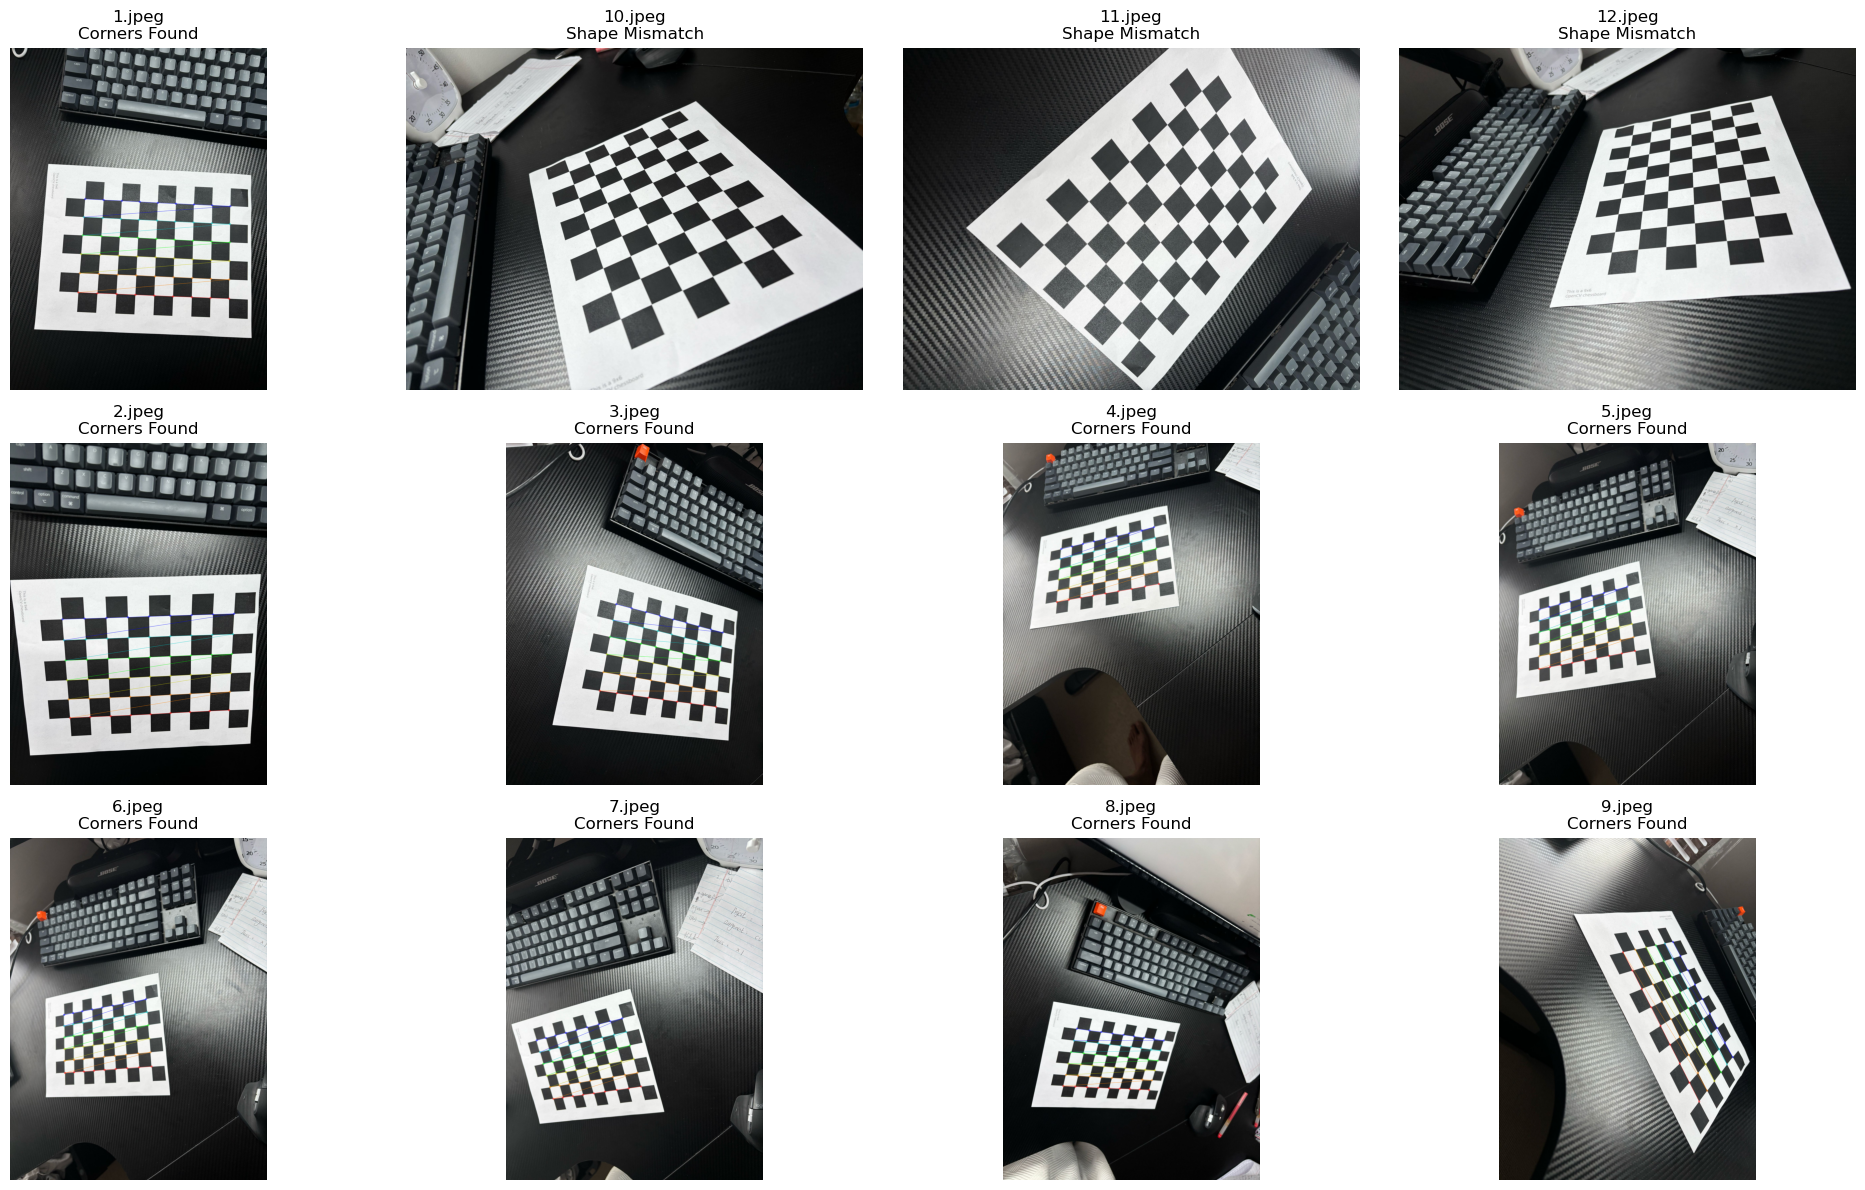

Found corners in 10 out of 13 images.

Performing camera calibration using 10 views...
Calibration successful!
Total Mean Reprojection Error: 0.07501 pixels

 Camera Calibration successful!
Camera Intrinsic Matrix (mtx_q2):
[[1.5624802e+03 0.0000000e+00 7.6303100e+02]
 [0.0000000e+00 1.5577948e+03 1.0154373e+03]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]

Distortion Coefficients (dist_q2):
[[ 2.7120e-01 -1.7070e+00 -1.4000e-03  6.0000e-04  3.2733e+00]]

Focal Length (pixels): fx=1562.48, fy=1557.79
Principal Point (pixels): cx=763.03, cy=1015.44


In [5]:
print(f"\n--- Q2: Calibrating Camera ---")

# --- Configuration ---
chessboard_size_q2 = (9, 6) # Internal corners
square_size_q2 = 29.0      # IMPORTANT (e.g., in mm)
image_dir_q2 = './my_camera_images' 
image_pattern_q2 = '*.jpeg' 

# Create directory if needed
os.makedirs(image_dir_q2, exist_ok=True)
print(f"-> Place images in: {os.path.abspath(image_dir_q2)}")
print(f"-> Using chessboard size: {chessboard_size_q2}, square size: {square_size_q2} units")

# --- Prepare Object Points Template (with measured size) ---
objp_template_q2 = np.zeros((chessboard_size_q2[0] * chessboard_size_q2[1], 3), np.float32)
objp_template_q2[:,:2] = np.mgrid[0:chessboard_size_q2[0], 0:chessboard_size_q2[1]].T.reshape(-1,2)
objp_template_q2 = objp_template_q2 * square_size_q2 # Scale to real-world size

# --- Find Corners ---
criteria_q2 = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
images_q2_paths = sorted(glob.glob(os.path.join(image_dir_q2, image_pattern_q2)))

if not images_q2_paths:
     print(f"\nError: No images found for Q2 in '{image_dir_q2}'. Please add images.")
else:
    objpoints_q2, imgpoints_q2, valid_fnames_q2, img_shape_q2 = find_chessboard_corners_in_images(
        images_q2_paths, chessboard_size_q2, criteria_q2, objp_template_q2, display_inline=True
    )

    # --- Calibrate ---
    ret_q2, mtx_q2, dist_q2, rvecs_q2, tvecs_q2, error_q2 = calibrate_and_evaluate(
        objpoints_q2, imgpoints_q2, img_shape_q2
    )

    # --- Display Results ---
    if ret_q2:
        print("\n Camera Calibration successful!")
        print("Camera Intrinsic Matrix (mtx_q2):")
        print(np.round(mtx_q2, 4))
        print("\nDistortion Coefficients (dist_q2):")
        print(np.round(dist_q2, 4))
        print(f"\nFocal Length (pixels): fx={mtx_q2[0,0]:.2f}, fy={mtx_q2[1,1]:.2f}")
        print(f"Principal Point (pixels): cx={mtx_q2[0,2]:.2f}, cy={mtx_q2[1,2]:.2f}")